In [1]:
import torch
import numpy as np 

In [10]:
a = torch.tensor([1,2], device=torch.device("cuda:0"))

In [11]:
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.distributions import Normal 

In [3]:
class base_class():
  def __init__(self):
    self.x = 0

  def increment(self, value):
    self.x += value

In [4]:
class super_class(base_class):
  def __init__(self):
    super(super_class, self).__init__()
    self.y = 1

In [20]:
obj = super_class()

In [22]:
obj.increment(10)
print(obj.x)

10


In [5]:
class Encoder(nn.Module):
  def __init__(self, capacity=64):
    super(Encoder, self).__init__()
    self.c = capacity
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1) # c x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1) #2c x 7 x 7
    self.mu = nn.Linear(in_features=self.c*2*7*7, out_features=6)
    self.logvar = nn.Linear(in_features=self.c*2*7*7, out_features=6)
    self.relu = nn.ReLU()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # self.device = torch.device('cpu')
    self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
    self.to(self.device)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = nn.Flatten()(x)
    mu = self.mu(x)
    logvar = self.logvar(x)

    return mu, logvar

In [25]:
encoder = Encoder()
x = torch.rand((64, 1, 28, 28), device=encoder.device)
mu, log_var = encoder(x)

In [6]:
class Decoder(nn.Module):
  def __init__(self, capacity=64):
    super(Decoder, self).__init__()
    self.c = capacity
    self.upsample = nn.Linear(in_features=6, out_features=self.c*2*7*7)
    self.deconv2 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
    self.deconv1 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1)
    self.relu = nn.ReLU()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # self.device = torch.device('cpu')
    self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
    self.to(self.device)

  def forward(self, x):
    x = self.upsample(x)
    x = nn.Unflatten(1, (self.c*2, 7, 7))(x)
    x = self.relu(self.deconv2(x))
    x = torch.sigmoid(self.deconv1(x))
    return x

In [31]:
decoder = Decoder()
x = torch.rand((64, 6), device=decoder.device)
image = decoder(x)
print(image.shape)

torch.Size([64, 1, 28, 28])


In [7]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # self.device = torch.device('cpu')
    self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
    self.to(self.device)

  def forward(self, x):
    mu, logvar = self.encoder(x)
    if self.training:
      std = logvar.mul(0.5).exp()
      dist = Normal(mu, std)
      latent_vec = dist.rsample() #dist.sample()
    else:
      latent_vec = mu
    image = self.decoder(latent_vec)

    return image, mu, logvar

In [34]:
vae = VAE()
x = torch.rand((64, 1, 28, 28), device=decoder.device)
image, _, __ = vae(x)
print(image.shape)

torch.Size([64, 1, 28, 28])


In [15]:
def vae_loss(recon_image, in_image, mu, logvar, beta):
  recon_loss = F.binary_cross_entropy(recon_image.view(-1, 784), in_image.view(-1, 784), reduction='sum')
  kldivergence = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

  return recon_loss + beta*kldivergence

In [16]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [17]:
img_tranforms = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_tranforms)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_tranforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [18]:
# Training loop

vae = VAE()
vae.train()
device = torch.device('cuda:0')

train_loss_avg = []
epochs = 50
for e in range(epochs):
  train_loss_avg.append(0)
  num_batch = 0
  for image_in, label in train_dataloader:
    image_in = image_in.to(device)
    image_recon, mu, logvar = vae(image_in)

    loss = vae_loss(image_recon, image_in, mu, logvar, 1)

    vae.optimizer.zero_grad()
    loss.backward()
    vae.optimizer.step()

    train_loss_avg[-1] += loss.item()
    num_batch += 1
  train_loss_avg[-1] = train_loss_avg[-1] / num_batch
  print("Epoch [%d/%d] average loss: %f" %(e+1, epochs, train_loss_avg[-1]))


Epoch [1/50] average loss: 20279.096018
Epoch [2/50] average loss: 16525.623463
Epoch [3/50] average loss: 15989.169383
Epoch [4/50] average loss: 15667.619924
Epoch [5/50] average loss: 15446.353655
Epoch [6/50] average loss: 15291.060214
Epoch [7/50] average loss: 15170.285056
Epoch [8/50] average loss: 15071.159731
Epoch [9/50] average loss: 14999.734077
Epoch [10/50] average loss: 14934.946845
Epoch [11/50] average loss: 14881.672500
Epoch [12/50] average loss: 14822.215194
Epoch [13/50] average loss: 14791.241117
Epoch [14/50] average loss: 14740.527866
Epoch [15/50] average loss: 14708.229432
Epoch [16/50] average loss: 14678.036822
Epoch [17/50] average loss: 14644.850276
Epoch [18/50] average loss: 14614.325772
Epoch [19/50] average loss: 14598.716843
Epoch [20/50] average loss: 14570.704605
Epoch [21/50] average loss: 14546.434037
Epoch [22/50] average loss: 14528.113754
Epoch [23/50] average loss: 14515.220287
Epoch [24/50] average loss: 14492.997035


TypeError: ignored

Text(0, 0.5, 'Loss')

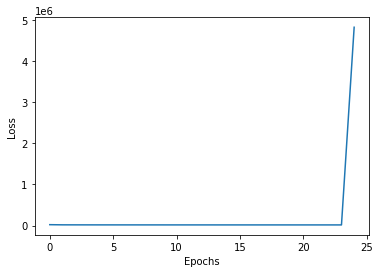

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')

Original images


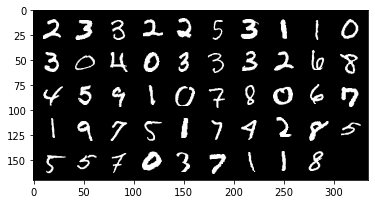

VAE reconstruction:


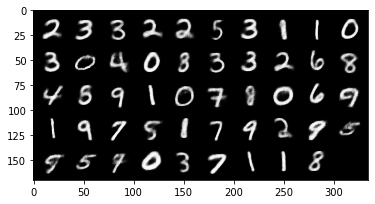

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)